# Visualize the best model performance

In [2]:
import pandas as pd
from dotenv import load_dotenv; load_dotenv()
from datetime import datetime, timedelta
import os

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib as mpl
import xarray as xr

from utils import load_Ran_ec_data, load_Ran_biomet_data

from scipy.optimize import curve_fit
import scipy.stats as stats
from scipy.special import gamma

from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import pymc as pm
import arviz as az

import pickle
import cloudpickle

%matplotlib widget
%load_ext autoreload
%autoreload 2

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Define model functions

In [3]:
full_model_eq = lambda T,X,params,inds: params['alpha'] + params['beta']*((T[inds, 0]-283.15)/10) + np.sum(params['gamma']*X[inds, :] + params['delta']*((T[inds, :]-283.15)/10)*X[inds, :],axis=1)

# Define visualization functions

In [51]:
def visualize_fit(model, obs, posterior, ticks, xlabel, ylabel, model_color, color_var=None, cb_label='', axs=None):
    # NB! These works only for negative values of model and obs
    # Figure definitions
    if axs is None:
        fig, axs = plt.subplots(figsize=(10,10), nrows=2, ncols=2)
        axs = axs.flatten()
        fig.subplots_adjust(bottom=0.2, hspace=0.3, wspace=0.4)
    fs=14
    ls=10


    # Find min and max value between model and measurements

    if np.min(model) < model.min():
        min_all = np.min(model)
    else:
        min_all = obs.min()
    min_all = min_all*1.15

    if np.max(model) > model.max():
        max_all = np.max(model)
    else:
        max_all = obs.max()
    max_all = max_all*0.85

    # Fig. 1
    axs[0].plot(obs.index, obs, 'o', markersize=4, markeredgecolor='k', markeredgewidth=0.5, color='w', label='Measured')
    axs[0].plot(obs.index, model, 'o', color=model_color, markeredgecolor='k', markeredgewidth=0.5, markersize=4, label='MAP estimate', alpha=.50)

    axs[0].set_ylabel(ylabel, fontsize=fs)

    axs[0].tick_params(axis='both', labelsize=ls)
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))
    axs[0].legend(loc='best', prop={'size': ls})

    # Fig. 2
    az.plot_ppc(posterior, num_pp_samples=300, ax=axs[1])
    axs[1].set_xlabel(xlabel, fontsize=fs)
    axs[1].tick_params(axis='both', labelsize=ls)

    # Fig. 3
    r2 = r2_score(obs.values, model)
    rmse = mean_squared_error(obs.values, model)
    if color_var is not None:
        im = axs[2].scatter(model, obs, c=color_var, s=3)
        cb = fig.colorbar(im)
        cb.set_label(cb_label, fontsize=fs)
        cb.ax.tick_params(labelsize=fs-1)
    else:
        im = axs[2].scatter(model, obs, c='gray', s=3)

    axs[2].set_xlabel(f'Modelled {ylabel}', fontsize=fs)
    axs[2].set_ylabel(f'Measured {xlabel}', fontsize=fs)
    axs[2].tick_params(axis='both', labelsize=ls)
    axs[2].text(min_all*0.95, max_all * 1.15, f'R$^2$ = {np.round(r2, 2)}', fontsize=ls)

    axs[2].text(min_all*0.95, max_all * 1.20, f'RMSE = {np.round(rmse, 5)}', fontsize=ls)
    axs[2].set_xlim(min_all, max_all)
    axs[2].set_ylim(min_all, max_all)
    axs[2].plot((-15,15), (-15,15), 'k--', linewidth=2)

    axs[2].set_xticks(ticks)
    axs[2].set_yticks(ticks)

    axs[2].set_aspect('equal')


    # Fig. 4

    residuals = model-obs
    if color_var is not None:
        axs[3].plot(color_var, residuals, color=model_color, marker='o', linestyle='', markeredgecolor='k', markersize=4, alpha=0.25)
        axs[3].set_ylabel('Model residuals', fontsize=fs)
        axs[3].set_xlabel(cb_label, fontsize=fs)
    else:
        axs[3].remove()

    


# Load data

In [5]:
data_n2o = pd.read_csv('data/inference_data_n2o.csv', index_col='time')
data_n2o.index = pd.to_datetime(data_n2o.index)

data_ch4 = pd.read_csv('data/inference_data_ch4.csv', index_col='time')
data_ch4.index = pd.to_datetime(data_ch4.index)

In [6]:
# For CH4 remove the two datapoint ln(CH4) ~= -7.1 & -4.4 as this makes produces warning in model comparison stage

data_ch4 = data_ch4.loc[data_ch4.F_CH4_ln > -4.1, :]

# Load best models

In [7]:
with open('models/full_model_n2o_st9_mutable.pkl','rb') as buff:
    model_n2o = cloudpickle.load(buff)

with open('models/full_model_ch4_st9_mutable.pkl','rb') as buff:
    model_ch4 = cloudpickle.load(buff)

# Define surface type dataframes

In [8]:
st_3_n2o = data_n2o.loc[:, ['Exposed peat','All ditches','Residue, ground and vegetation']]
st_5_n2o = data_n2o.loc[:, ['Exposed peat','All ditches','Logging residue','Light moss','Green vegetation and trees']]
st_9_n2o = data_n2o.loc[:, ['Fallen tree', 'Dry branch', 'Exposed peat', 'Light moss', 'Dark moss', 'Green vegetation', 'Ditch', 'Tree', 'Covered ditch',]]
st_6_n2o = data_n2o.loc[:, ['Exposed peat','Ditch','Covered ditch','Logging residue','Light moss','Green vegetation and trees']]
st_4_n2o = data_n2o.loc[:, ['Exposed peat','Ditch','Covered ditch','Residue, ground and vegetation']]

In [9]:
st_3_ch4 = data_ch4.loc[:, ['Exposed peat','All ditches','Residue, ground and vegetation']]
st_5_ch4 = data_ch4.loc[:, ['Exposed peat','All ditches','Logging residue','Light moss','Green vegetation and trees']]
st_9_ch4 = data_ch4.loc[:, ['Fallen tree', 'Dry branch', 'Exposed peat', 'Light moss', 'Dark moss', 'Green vegetation', 'Ditch', 'Tree', 'Covered ditch',]]
st_6_ch4 = data_ch4.loc[:, ['Exposed peat','Ditch','Covered ditch','Logging residue','Light moss','Green vegetation and trees']]
st_4_ch4 = data_ch4.loc[:, ['Exposed peat','Ditch','Covered ditch','Residue, ground and vegetation']]

/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


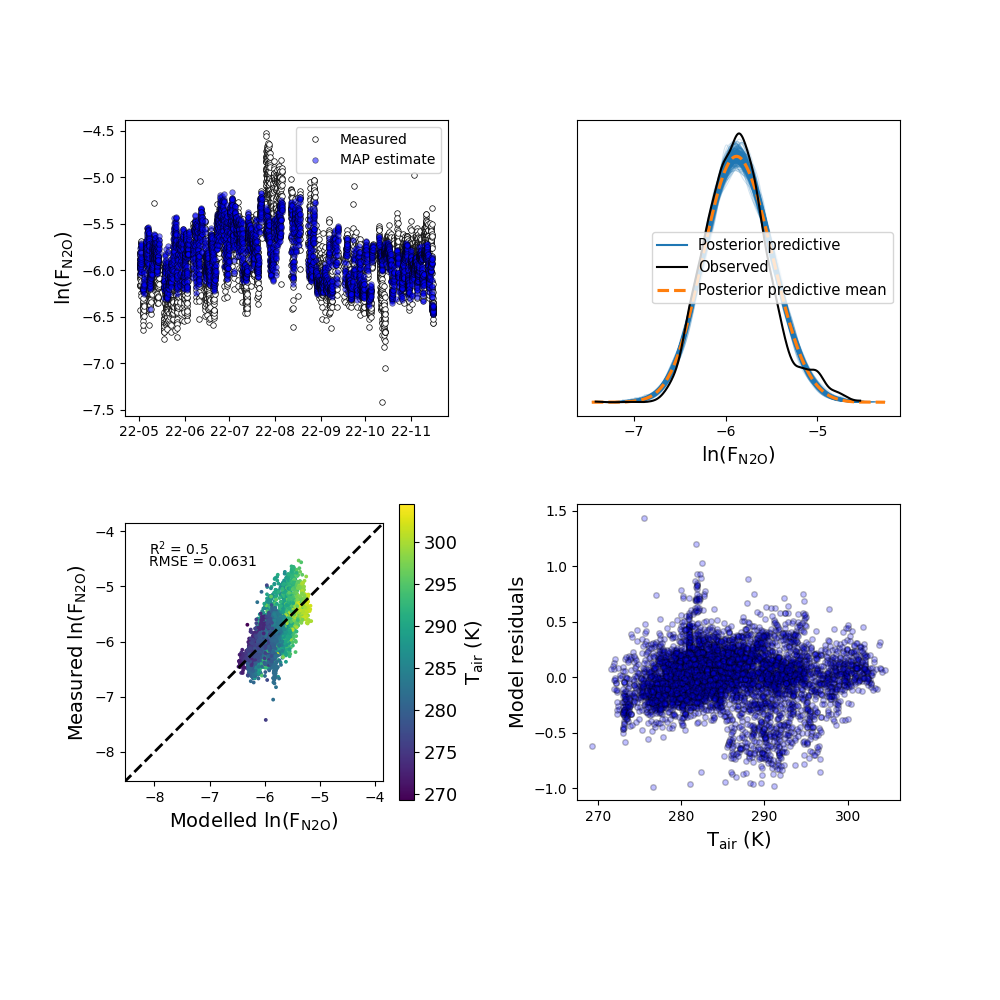

In [53]:
model = full_model_eq(model_n2o['model']['T_air'].eval(), st_9_n2o.values, model_n2o['map'], np.arange(data_n2o.shape[0]))
obs = data_n2o.loc[:, 'F_N2O_ln']

prior = model_n2o['idata']['prior']
data_inds = np.random.choice(st_9_n2o.shape[0], size=2000)
pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
prior_values = full_model_eq(model_n2o['model']['T_air'].eval(), st_9_n2o.values, pp, data_inds)

posterior = model_n2o['model_res']

xlabel = 'ln(F$_{\mathrm{N2O}}$)'
ylabel = 'ln(F$_{\mathrm{N2O}}$)'

color_var = data_n2o.T_air_K.values
cb_label = 'T$_{\mathrm{air}}$ (K)'

visualize_fit(model, obs, posterior, [-4, -5, -6, -7, -8], xlabel, ylabel, 'b', color_var=color_var, cb_label=cb_label, axs=None)

/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


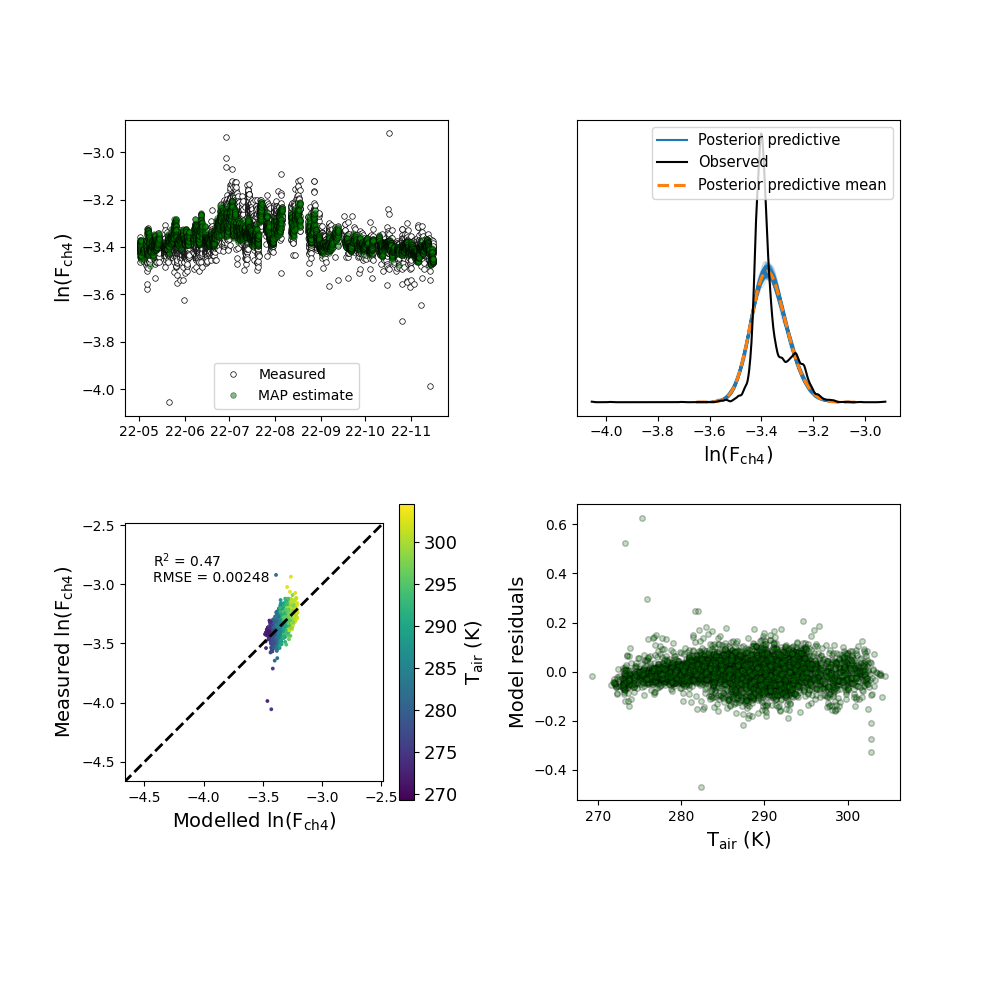

In [54]:
model = full_model_eq(model_ch4['model']['T_air'].eval(), st_9_ch4.values, model_ch4['map'], np.arange(data_ch4.shape[0]))
obs = data_ch4.loc[:, 'F_CH4_ln']

prior = model_ch4['idata']['prior']
data_inds = np.random.choice(st_9_ch4.shape[0], size=2000)
pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
prior_values = full_model_eq(model_ch4['model']['T_air'].eval(), st_9_ch4.values, pp, data_inds)

posterior = model_ch4['model_res']

xlabel = 'ln(F$_{\mathrm{ch4}}$)'
ylabel = 'ln(F$_{\mathrm{ch4}}$)'

color_var = data_ch4.T_air_K.values
cb_label = 'T$_{\mathrm{air}}$ (K)'

visualize_fit(model, obs, posterior, [-4.5, -4, -3.5, -3, -2.5], xlabel, ylabel, 'g', color_var=color_var, cb_label=cb_label, axs=None)